# Reading current covid-19 data from a github-repo and displaying it using pandas

In [1]:
!pip install pandas numpy scipy matplotlib lmfit;

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# The data source

In [3]:
source_file = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [4]:
df = pd.read_csv(source_file)

# Exploring the data

In [5]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,53,59,70,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,581,639,639,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,160,178,178,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,129,149,149,197,238,428,566,673,790,900


# Adapting the datas shape for easier plotting

In [6]:
df_base = df.groupby('Country/Region').agg('sum').drop('Lat	Long'.split(),axis=1).T
df_base.index = pd.to_datetime(df_base.index, infer_datetime_format=True)

In [7]:
df_base.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia
2020-03-15,16,42,48,1,1,45,26,297,860,23,...,6,3499,3,98,1145,4,1,10,56,0
2020-03-16,21,51,54,2,1,56,52,377,1018,15,...,18,4632,7,98,1551,8,6,17,61,0
2020-03-17,22,55,60,39,1,68,78,452,1332,28,...,47,6421,14,98,1960,29,10,33,66,0
2020-03-18,22,59,74,39,1,79,84,568,1646,28,...,98,7783,14,113,2642,50,15,36,75,2
2020-03-19,22,64,87,53,1,97,115,681,2013,44,...,192,13677,16,140,2716,79,23,42,85,2


In [8]:
df_base['World'] = df_base.sum(axis=1)

# ... checking which countries I can actually visualize

In [9]:
df_base.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       ...
       'US', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay',
       'Uzbekistan', 'Venezuela', 'Vietnam', 'Zambia', 'World'],
      dtype='object', name='Country/Region', length=156)

# What I am interested in. Feel free to manipulate.

In [10]:
requested_countries = 'Germany China US World'.split()
df_requested = df_base[requested_countries]

# Also want to see the growthrate. Since I expect it to be spiky, lets apply a moving average.

In [11]:
averaging_window_size = 3
df_requested_growthrate = df_requested.pct_change().rolling(window=averaging_window_size).mean().apply(lambda x: 100*x)

# Actually generate the plots, resized them a bit for better visual inspection

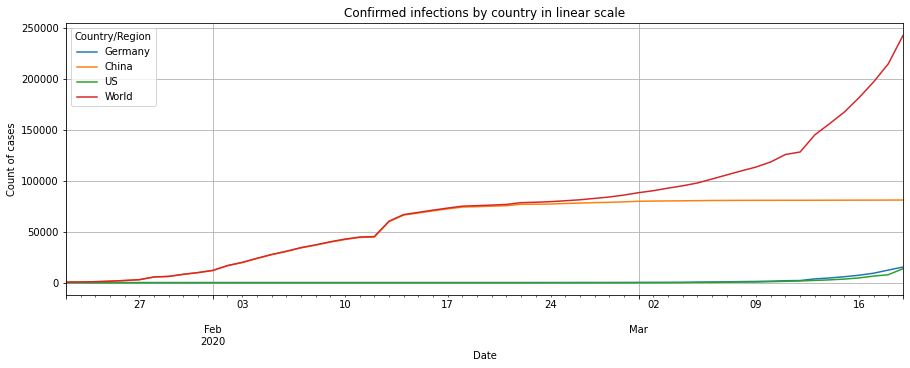

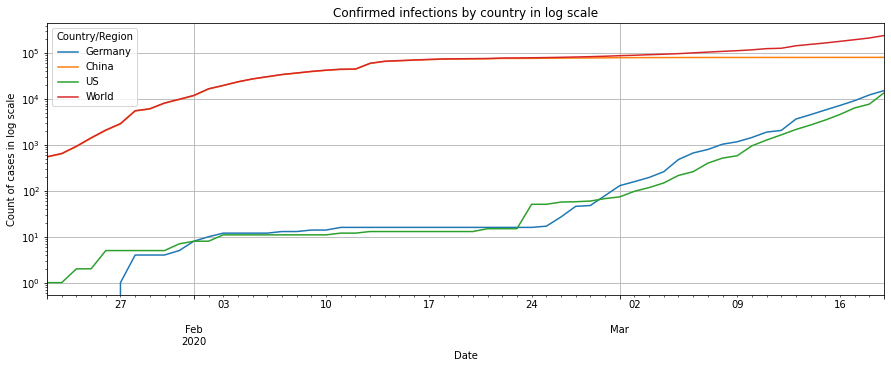

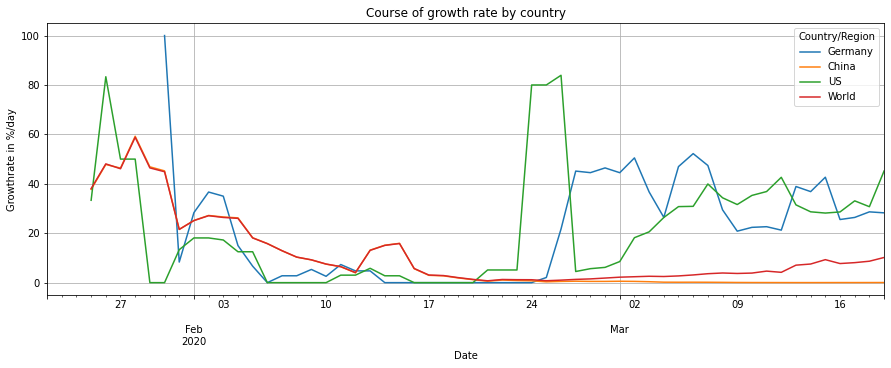

In [12]:
figure_size = (15,5)
str_timestamp = datetime.now().strftime('%Y%m%d')

ax0 = df_requested.plot(grid=True,title='Confirmed infections by country in linear scale',figsize=figure_size)
ax0.set_xlabel('Date')
ax0.set_ylabel('Count of cases');
plt.savefig(f'{str_timestamp}_covid_19_confirmed_infections_by_country_normal_scale.svg', format='svg', bbox_inches='tight')

ax1 = df_requested.plot(grid=True,logy=True,title='Confirmed infections by country in log scale',figsize=figure_size)
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of cases in log scale');
plt.savefig(f'{str_timestamp}_covid_19_confirmed_infections_by_country_log_scale.svg', format='svg', bbox_inches='tight')

ax2 = df_requested_growthrate.plot(grid=True,title='Course of growth rate by country',figsize=figure_size)
ax2.set_xlabel('Date')
ax2.set_ylabel('Growthrate in %/day');
plt.savefig(f'{str_timestamp}_covid_19_daily_growthrate_by_country.svg', format="svg", bbox_inches='tight')

# Trying to aproximate a model

In [13]:
import numpy as np
from lmfit.models import PowerLawModel
from lmfit import Model

In [14]:
def logistic(x,L,tau):
    return L/(1+np.power(10,-x/tau))

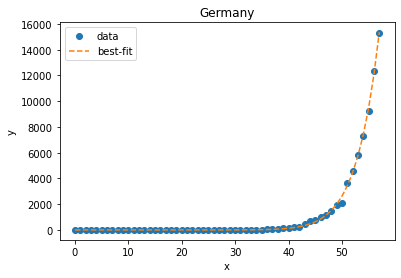

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 760
    # data points      = 58
    # variables        = 2
    chi-square         = 645820.086
    reduced chi-square = 11532.5015
    Akaike info crit   = 544.434327
    Bayesian info crit = 548.555213
[[Variables]]
    amplitude:  2.8557e-20 +/- 1.4153e-20 (49.56%) (init = 0.1395744)
    exponent:   13.5149543 +/- 0.12342187 (0.91%) (init = 1.245662)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = -1.000

***********************



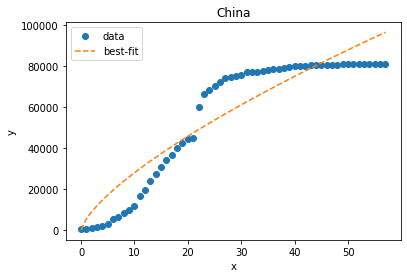

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 58
    # variables        = 2
    chi-square         = 6.7426e+09
    reduced chi-square = 1.2040e+08
    Akaike info crit   = 1081.13338
    Bayesian info crit = 1085.25426
[[Variables]]
    amplitude:  5413.88417 +/- 1115.18531 (20.60%) (init = 23161.11)
    exponent:   0.71295703 +/- 0.05622648 (7.89%) (init = 0.1634479)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = -0.994

***********************



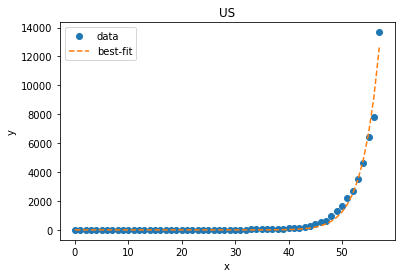

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1159
    # data points      = 58
    # variables        = 2
    chi-square         = 4240756.23
    reduced chi-square = 75727.7899
    Akaike info crit   = 653.588931
    Bayesian info crit = 657.709817
[[Variables]]
    amplitude:  9.3566e-28 +/- 2.0943e-27 (223.83%) (init = 29.23306)
    exponent:   17.7290028 +/- 0.55592854 (3.14%) (init = 0.1800907)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = -1.000

***********************



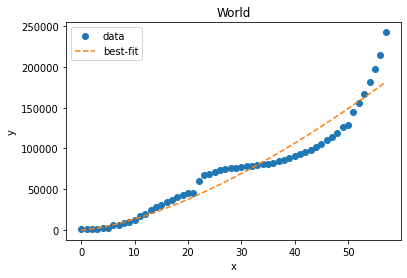

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 58
    # variables        = 2
    chi-square         = 1.4064e+10
    reduced chi-square = 2.5114e+08
    Akaike info crit   = 1123.77221
    Bayesian info crit = 1127.89310
[[Variables]]
    amplitude:  421.373438 +/- 146.150418 (34.68%) (init = 26659.57)
    exponent:   1.50006501 +/- 0.09100136 (6.07%) (init = 0.1734888)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = -0.998

***********************



In [15]:
#model = Model(logistic)
model = PowerLawModel()
country_models = dict()
for country in df_requested.columns:
    x = np.arange(0,len(df_requested[country].values))
    y = df_requested[country].values
    #params = model.make_params(L=1,tau=1)
    params = model.guess(y,x=x)
    result = model.fit(y, params, x=x)
    country_models[country] = {'params':params, 'result':result}
    result.plot_fit(datafmt='o',fitfmt='--')
    plt.title(country)
    plt.show()
    print(result.fit_report())    
    print('\n***********************\n')

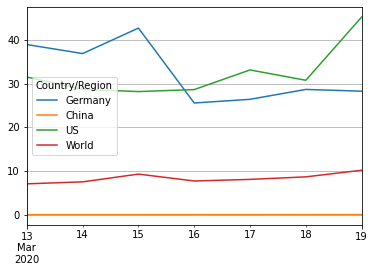

In [16]:
df_requested_growthrate.last('7D').plot(grid=True)

In [17]:
df_requested.tail()

Country/Region,Germany,China,US,World
2020-03-15,5795,81003,3499,167446
2020-03-16,7272,81033,4632,181527
2020-03-17,9257,81058,6421,197142
2020-03-18,12327,81102,7783,214910
2020-03-19,15320,81156,13677,242708


In [18]:
df_requested_growthrate.tail()

Country/Region,Germany,China,US,World
2020-03-15,42.668350,0.029235,28.162304,9.303120
2020-03-16,25.546599,0.036226,28.613110,7.729919
2020-03-17,26.391457,0.033332,33.104268,8.094615
2020-03-18,28.649354,0.040723,30.738318,8.674699
2020-03-19,28.246869,0.050572,45.187809,10.183179
